In [2]:
import xarray as xr

ds_url = (
    "https://storage.googleapis.com/ar6-lsl-simulations-public-standard/"
    "tide-gauges/full_sample_workflows/wf_1e/ssp119/total-workflow.zarr"
)

ds = xr.open_dataset(ds_url, engine="zarr")  # <-- remove chunks="auto"
print(ds)


<xarray.Dataset> Size: 729MB
Dimensions:           (samples: 20000, years: 9, locations: 1012)
Coordinates:
  * samples           (samples) int64 160kB 0 1 2 3 ... 19996 19997 19998 19999
  * years             (years) int64 72B 2020 2030 2040 2050 ... 2080 2090 2100
  * locations         (locations) int64 8kB 1 2 3 5 7 ... 2329 2330 2356 2358
    lat               (locations) float64 8kB ...
    lon               (locations) float64 8kB ...
Data variables:
    sea_level_change  (samples, years, locations) float32 729MB ...
Attributes:
    citation:              In order to document the impact of these sea-level...
    description:           Total sea-level change for workflow
    extra_info_url:        https://github.com/Rutgers-ESSP/IPCC-AR6-Sea-Level...
    history:               Created Fri Jun 18 14:00:48 2021
    license:               The IPCC AR6 Sea-Level Rise Projections are licens...
    source:                FACTS: Post-processed total among available contri...
    zarr_pro

In [4]:
import numpy as np

# 1. Halmstad coordinates
halmstad_lat = 56.67446
halmstad_lon = 12.85676

# 2. Extract lat/lon arrays from the dataset
lats = ds["lat"].values    # shape: (locations,)
lons = ds["lon"].values    # shape: (locations,)

# 3. Compute approximate squared distance on the sphere (longitude scaled by cos(lat))
dist2 = (lats - halmstad_lat)**2 + ((lons - halmstad_lon) * np.cos(np.deg2rad(halmstad_lat)))**2

# 4. Index of closest tide-gauge location
idx = np.argmin(dist2)

closest_loc_id = ds["locations"].values[idx]
closest_lat = float(lats[idx])
closest_lon = float(lons[idx])

print("Closest AR6 tide-gauge location:")
print("  location id:", closest_loc_id)
print("  lat:", closest_lat)
print("  lon:", closest_lon)


Closest AR6 tide-gauge location:
  location id: 73
  lat: 57.1
  lon: 12.22


In [8]:
import pandas as pd

locs = pd.read_csv(
    "https://raw.githubusercontent.com/Rutgers-ESSP/IPCC-AR6-Sea-Level-Projections/main/location_list.txt",
    sep="\t",
    header=None,
    names=["name", "loc_id", "lat", "lon"],
)

print(locs.head())



          name  loc_id    lat    lon
0        BREST       1  48.38  -4.49
1  SWINOUJSCIE       2  53.92  14.23
2    SHEERNESS       3  51.45   0.74
3     HOLYHEAD       5  53.31  -4.62
4   CUXHAVEN_2       7  53.87   8.72


In [9]:
row = locs.loc[locs["loc_id"] == int(closest_loc_id)]
print(row)


       name  loc_id   lat    lon
55  VARBERG      73  57.1  12.22


In [10]:
# Find Varberg in the location list
varberg_rows = locs[locs["name"].str.contains("VARBERG", case=False)]
varberg_ids = varberg_rows["loc_id"].astype(int).values
print("Varberg location IDs:", varberg_ids)
print(varberg_rows)

# Extract sea-level change samples for Varberg from the AR6 dataset
# sea_level_change dims should be (samples, years, locations)
varberg_sl = ds["sea_level_change"].sel(locations=varberg_ids)

print(varberg_sl)

Varberg location IDs: [73]
       name  loc_id   lat    lon
55  VARBERG      73  57.1  12.22
<xarray.DataArray 'sea_level_change' (samples: 20000, years: 9, locations: 1)> Size: 720kB
[180000 values with dtype=float32]
Coordinates:
  * samples    (samples) int64 160kB 0 1 2 3 4 ... 19995 19996 19997 19998 19999
  * years      (years) int64 72B 2020 2030 2040 2050 2060 2070 2080 2090 2100
  * locations  (locations) int64 8B 73
    lat        (locations) float64 8B 57.1
    lon        (locations) float64 8B 12.22
Attributes:
    units:    mm


In [11]:
# Squeeze locations so we only have (samples, years)
varberg_sl_da = varberg_sl.squeeze("locations", drop=True)

# Original AR6 years and values
years_ar6 = varberg_sl_da["years"].values.astype(int)  # e.g. [2020, 2030, ...]
sl_vals = varberg_sl_da.values                         # shape: (n_samples, n_years)

# Target annual years: from 2010 back to last AR6 year
start_year = 2010
end_year = int(years_ar6.max())
target_years = np.arange(start_year, end_year + 1)

n_samples, n_years = sl_vals.shape
X_annual = np.empty((n_samples, target_years.size), dtype=float)

for j in range(n_samples):
    y = sl_vals[j, :]
    t0, t1 = years_ar6[0], years_ar6[1]
    slope0 = (y[1] - y[0]) / (t1 - t0)

    # Backward (t < first AR6 year): linear extrapolation using first two AR6 points
    mask_back = target_years < t0
    X_annual[j, mask_back] = y[0] + slope0 * (target_years[mask_back] - t0)

    # From first AR6 year onward: linear interpolation between AR6 points
    mask_main = ~mask_back
    X_annual[j, mask_main] = np.interp(target_years[mask_main], years_ar6, y)

# Wrap back into an xarray DataArray for convenience
varberg_sl_annual = xr.DataArray(
    X_annual,
    dims=("samples", "year"),
    coords={"samples": varberg_sl_da["samples"], "year": target_years},
    name="sea_level_change_annual",
)

print(varberg_sl_annual)


<xarray.DataArray 'sea_level_change_annual' (samples: 20000, year: 91)> Size: 15MB
array([[ 58. ,  57. ,  56. , ..., 100.4, 116.2, 132. ],
       [ 52. ,  57. ,  62. , ..., 234.4, 223.7, 213. ],
       [ 13. ,  11.4,   9.8, ..., -37. , -43.5, -50. ],
       ...,
       [-19. , -20.6, -22.2, ...,  38.2,  57.1,  76. ],
       [ 21. ,  23.2,  25.4, ..., 106.6, 101.3,  96. ],
       [ -1. ,   1.7,   4.4, ..., 228.8, 233.9, 239. ]], shape=(20000, 91))
Coordinates:
  * samples  (samples) int64 160kB 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
  * year     (year) int64 728B 2010 2011 2012 2013 2014 ... 2097 2098 2099 2100


In [12]:
# Assume you have an xarray.DataArray called `varberg_sl_annual`
# with dims like ("sample", "year") and a "year" coordinate.

years = varberg_sl_annual["year"].values
sl_samples = varberg_sl_annual.values.astype("float32")  # smaller file, enough precision

# Save compressed for efficient storage / loading later
np.savez_compressed(
    "varberg_sl_annual_2010_2200.npz",
    years=years,
    sl=sl_samples,
)


In [13]:

# Example of how to load it later:
data = np.load("varberg_sl_annual_2010_2200.npz")
years = data["years"]
sl_samples = data["sl"]

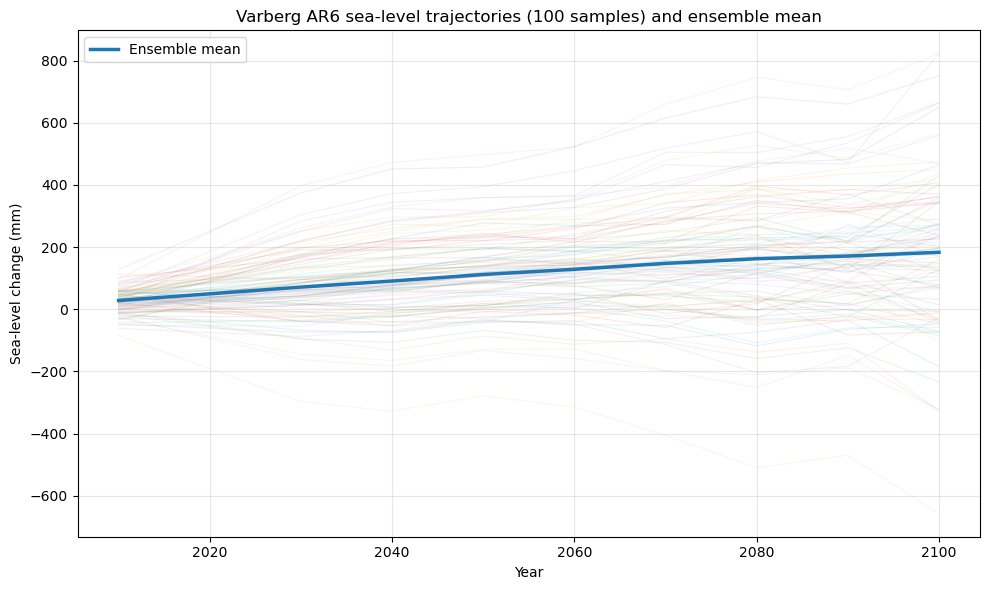

In [15]:
import matplotlib.pyplot as plt

# Assume `varberg_sl_annual` is already defined as before
years = varberg_sl_annual["year"].values
sl_samples = varberg_sl_annual.values  # shape: (n_samples, n_years)

n_samples = sl_samples.shape[0]
n_plot = min(100, n_samples)

# Pick 100 random sample paths (or fewer if <100 available)
rng = np.random.default_rng()
idx = rng.choice(n_samples, size=n_plot, replace=False)

plt.figure(figsize=(10, 6))

# Plot the random sample paths
for j in idx:
    plt.plot(years, sl_samples[j, :], alpha=0.1, linewidth=0.8)

# Plot the ensemble mean
mean_path = sl_samples.mean(axis=0)
plt.plot(years, mean_path, linewidth=2.5, label="Ensemble mean")

plt.xlabel("Year")
plt.ylabel("Sea-level change (mm)")
plt.title("Varberg AR6 sea-level trajectories (100 samples) and ensemble mean")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# CELL 1 – Load and clean Halmstad data (2010–2024, cm)

import pandas as pd
import matplotlib.pyplot as plt

# File is assumed to be in the same directory as the notebook
file_path = "HALMSTAD SJÖV - RH 2000.csv"

# Load CSV (semicolon-separated, header on first row)
df = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df["datetime"] = pd.to_datetime(df["Datum Tid (UTC)"])
df = df.set_index("datetime")

# Keep only the sea level column (in cm) and rename it
df = df[["Havsvattenstånd"]].copy()
df = df.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to 2010–2024
df = df.loc["2010-01-01":"2024-12-31"]

# Drop any remaining missing values (should be rare)
df = df.dropna(subset=["sea_level_cm"])

print(df.head())
print(df.tail())
print("Number of observations in 2010–2024:", len(df))


                     sea_level_cm
datetime                         
2010-01-01 00:00:00         -20.3
2010-01-01 01:00:00         -24.6
2010-01-01 02:00:00         -25.5
2010-01-01 03:00:00         -24.1
2010-01-01 04:00:00         -21.9
                     sea_level_cm
datetime                         
2024-12-31 19:00:00          56.0
2024-12-31 20:00:00          49.1
2024-12-31 21:00:00          60.1
2024-12-31 22:00:00          63.0
2024-12-31 23:00:00          54.4
Number of observations in 2010–2024: 127824


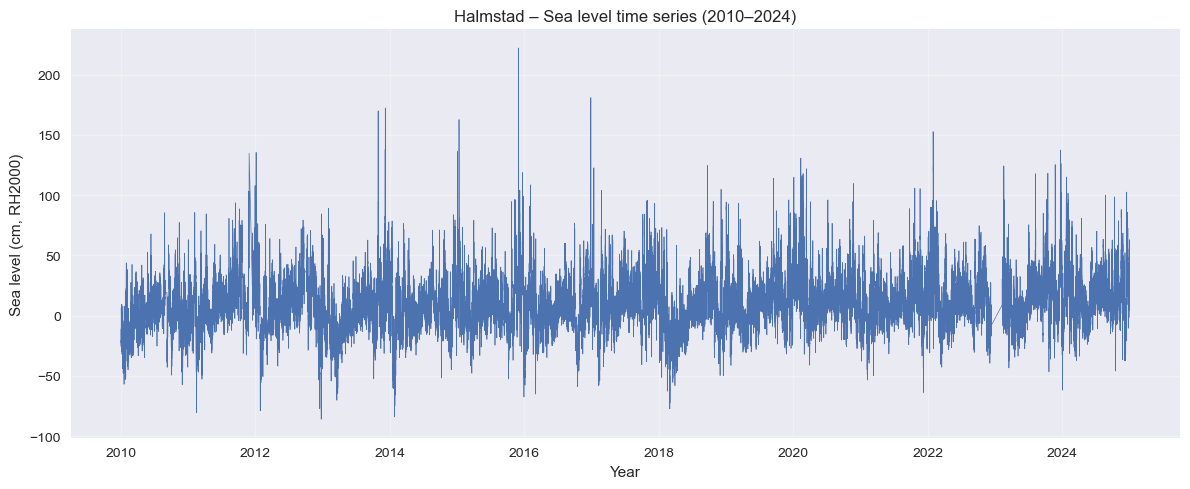

In [19]:
# CELL 2 – Plot full sea-level time series (2010–2024, cm)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df.index, df["sea_level_cm"], linewidth=0.5)
ax.set_title("Halmstad – Sea level time series (2010–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Sea level (cm, RH2000)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_39368\1380621011.py:4: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = df["sea_level_cm"].resample("A").max()


Annual block maxima (cm):
datetime
2010     85.4
2011    134.7
2012    135.4
2013    172.2
2014     83.7
2015    222.0
2016    180.8
2017    122.6
2018    124.5
2019    114.0
2020    130.6
2021    105.8
2022    152.6
2023    137.4
2024    115.0
Name: sea_level_cm, dtype: float64


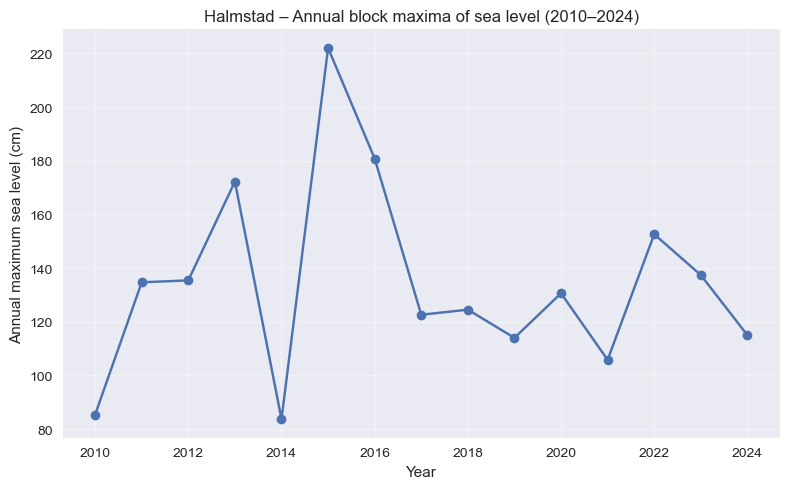

In [20]:
# CELL 3 – Annual block maxima (classic EVT block-maxima series)

# Annual maxima (calendar years)
annual_max = df["sea_level_cm"].resample("A").max()
annual_max.index = annual_max.index.year  # use year as index label

print("Annual block maxima (cm):")
print(annual_max)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(annual_max.index, annual_max.values, marker="o", linestyle="-")
ax.set_title("Halmstad – Annual block maxima of sea level (2010–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Annual maximum sea level (cm)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


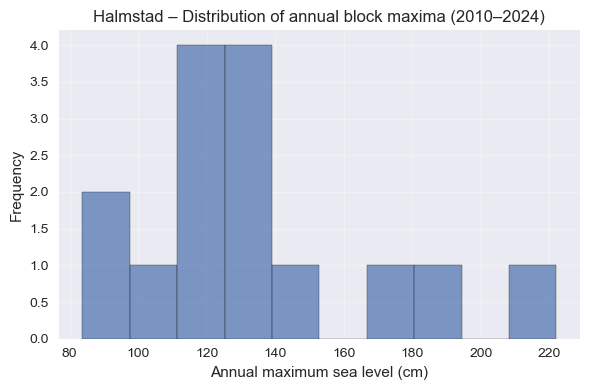

In [21]:
# CELL 4 – Histogram of annual block maxima (EVT diagnostic)

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(annual_max.values, bins=10, edgecolor="black", alpha=0.7)
ax.set_title("Halmstad – Distribution of annual block maxima (2010–2024)")
ax.set_xlabel("Annual maximum sea level (cm)")
ax.set_ylabel("Frequency")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_39368\1878423156.py:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean = df["sea_level_cm"].resample("A").mean()
C:\Users\johan\AppData\Local\Temp\ipykernel_39368\1878423156.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max = df["sea_level_cm"].resample("A").max()


=== Annual MEAN sea level (cm) ===
Slope (per year): 0.7565 cm/year
p-value for nonzero slope: 0.01099
R-squared: 0.403

=== Annual MAXIMUM sea level (cm) ===
Slope (per year): -0.3136 cm/year
p-value for nonzero slope: 0.8912
R-squared: 0.001



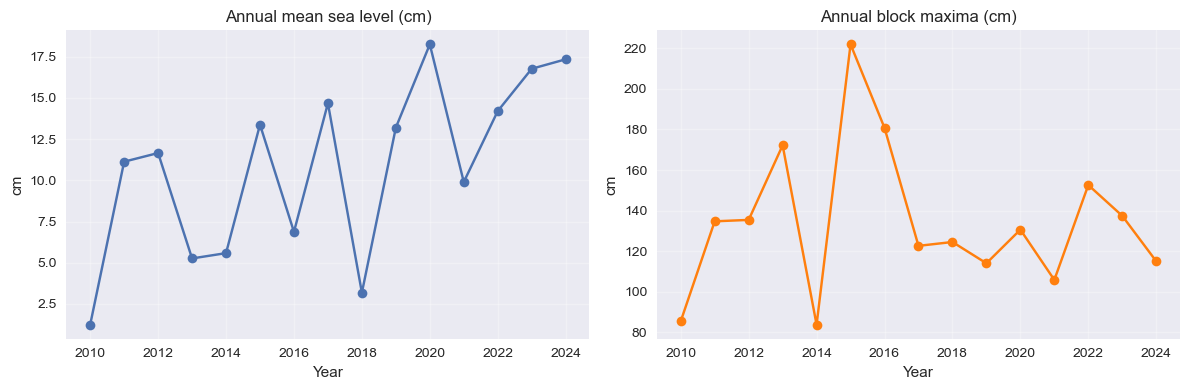

In [23]:
# CELL – Trend tests for annual mean and annual block maxima

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# 1. Annual mean sea level (cm)
annual_mean = df["sea_level_cm"].resample("A").mean()
annual_mean.index = annual_mean.index.year  # use year as integer index

# 2. Annual block maxima (cm)
annual_max = df["sea_level_cm"].resample("A").max()
annual_max.index = annual_max.index.year

# Put years into a numeric array
years_mean = annual_mean.index.values.astype(float)
years_max = annual_max.index.values.astype(float)

# Center years to reduce collinearity (optional but nice)
years_mean_c = years_mean - years_mean.mean()
years_max_c = years_max - years_max.mean()

# 3. Linear trend test for annual mean (OLS slope != 0)
slope_mean, intercept_mean, r_mean, p_mean, stderr_mean = stats.linregress(
    years_mean_c, annual_mean.values
)

# 4. Linear trend test for annual maxima (OLS slope != 0)
slope_max, intercept_max, r_max, p_max, stderr_max = stats.linregress(
    years_max_c, annual_max.values
)

print("=== Annual MEAN sea level (cm) ===")
print(f"Slope (per year): {slope_mean:.4f} cm/year")
print(f"p-value for nonzero slope: {p_mean:.4g}")
print(f"R-squared: {r_mean**2:.3f}")
print()

print("=== Annual MAXIMUM sea level (cm) ===")
print(f"Slope (per year): {slope_max:.4f} cm/year")
print(f"p-value for nonzero slope: {p_max:.4g}")
print(f"R-squared: {r_max**2:.3f}")
print()

# Quick visual check
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(annual_mean.index, annual_mean.values, marker="o")
axes[0].set_title("Annual mean sea level (cm)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("cm")
axes[0].grid(alpha=0.3)

axes[1].plot(annual_max.index, annual_max.values, marker="o", color="tab:orange")
axes[1].set_title("Annual block maxima (cm)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("cm")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\johan\AppData\Local\Temp\ipykernel_39368\2203644971.py:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  max_values = df["sea_level_cm"].resample("A").max()
C:\Users\johan\AppData\Local\Temp\ipykernel_39368\2203644971.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  max_times = df["sea_level_cm"].resample("A").apply(lambda s: s.idxmax())


Month of annual maximum for each year:
    year  month
0   2010      8
1   2011     11
2   2012      1
3   2013     12
4   2014     12
5   2015     11
6   2016     12
7   2017      1
8   2018      9
9   2019      9
10  2020      2
11  2021     10
12  2022      1
13  2023     12
14  2024      1


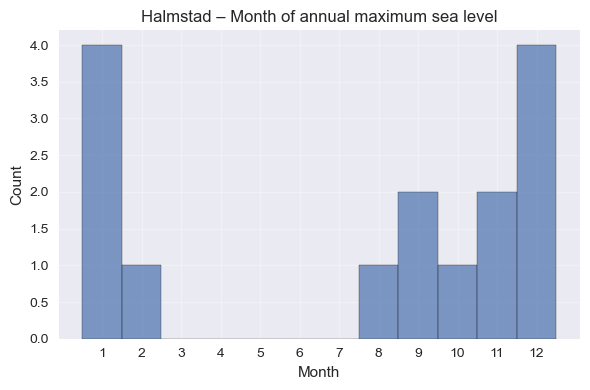

In [25]:
# CELL – Month-of-year of annual maxima (seasonality check, fixed)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Recompute annual maxima and their timestamps
max_values = df["sea_level_cm"].resample("A").max()

# For each year, take the timestamp where the maximum occurs
# (older pandas versions don't have Resampler.idxmax, so we use apply)
max_times = df["sea_level_cm"].resample("A").apply(lambda s: s.idxmax())

max_values.index = max_values.index.year
max_times.index = max_times.index.year

max_months = max_times.dt.month  # 1=Jan, ..., 12=Dec

print("Month of annual maximum for each year:")
print(pd.DataFrame({"year": max_months.index, "month": max_months.values}))

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(max_months.values, bins=np.arange(1, 14) - 0.5, edgecolor="black", alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.set_title("Halmstad – Month of annual maximum sea level")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# CELL 1 – Reload full Halmstad series and keep 2009–2025 (cm)

import pandas as pd
import matplotlib.pyplot as plt

file_path = "HALMSTAD SJÖV - RH 2000.csv"

# Load CSV (semicolon-separated, header on first row)
df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

# Keep only the sea level column (in cm) and rename it
df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad window around 2009–2025 (in case the file is larger)
df_full = df_full.loc["2009-01-01":"2025-12-31"]

print(df_full.head())
print(df_full.tail())
print("Number of observations 2009–2025:", len(df_full))


                     sea_level_cm
datetime                         
2009-04-27 15:00:00          -6.2
2009-04-27 16:00:00          -5.7
2009-04-27 17:00:00          -6.8
2009-04-27 18:00:00          -2.2
2009-04-27 19:00:00           5.7
                     sea_level_cm
datetime                         
2025-11-02 20:00:00          39.4
2025-11-02 21:00:00          36.8
2025-11-02 22:00:00          34.4
2025-11-02 23:00:00          33.9
2025-11-03 00:00:00          32.0
Number of observations 2009–2025: 140713


## Latent-covariate GEV model

We will use storm-year (Jul–Jun) block maxima $Y_t$ as our extreme-value data.  
Let $t$ index storm-years: $t = t_0, \dots, t_T$.

---

### 1. Latent mean sea-level (MSL) path $X_t$

We treat $X_{t_0:T}$ as latent, with prior given by the AR6 ensemble:
$$
X_{t_0:T} \sim p_{\mathrm{AR6}}(X_{t_0:T}),
$$
where $p_{\mathrm{AR6}}$ is approximated by the empirical distribution
of AR6 Varberg sample paths (after interpolation, back-extension, and
unit conversion).

Concretely, we will have an array  
`X_prior_paths_cm[sample, year_index]`  
giving MSL in cm for each AR6 sample path and storm-year.

---

### 2. Extremes conditional on $X_t$

Given $X_t$, storm-year maxima follow a non-stationary GEV:
$$
Y_t \mid X_t, \theta \sim \mathrm{GEV}\bigl(\mu(X_t; \theta),\, \sigma(X_t; \theta),\, \xi\bigr).
$$

We use a simple parametrisation:
$$
\mu_t = \beta_0 + \beta_1 X_t, \qquad
\log \sigma_t = \alpha_0, \qquad
\xi_t = \xi.
$$

Here $X_t$ is in cm (RH2000-based), consistent with the units of $Y_t$.

---

### 3. Observed data and marginal likelihood

We observe only the storm-year maxima $Y_t$ for $t \in \{t_0, \dots, t_T\}$, not $X_t$.
For each $t$, the marginal likelihood is
$$
p(Y_t \mid \theta)
= \int p(Y_t \mid X_t, \theta)\, p_{\mathrm{AR6}}(X_t)\, dX_t.
$$

If we later fit this in a Bayesian way, the joint posterior is
$$
p(\theta, X_{t_0:T} \mid Y_{t_0:T})
\propto
\Bigl[\prod_t p(Y_t \mid X_t, \theta)\Bigr]\,
p_{\mathrm{AR6}}(X_{t_0:T})\, \pi(\theta),
$$
where $\pi(\theta)$ is the prior on the GEV parameters.

In practice we approximate $p_{\mathrm{AR6}}$ by a finite ensemble of sample paths and
treat $X_{t_0:T}$ as a latent covariate path drawn from that ensemble.

---

### Quantities we prepare

We will construct

- storm-year block maxima $Y_t$ (in cm),
- the corresponding storm-year indices,
- and an AR6-based prior matrix of $X_t$ values (in cm) for those years.


Full Halmstad series (truncated to 2009–2025):
                     sea_level_cm
datetime                         
2009-04-27 15:00:00          -6.2
2009-04-27 16:00:00          -5.7
2009-04-27 17:00:00          -6.8
2009-04-27 18:00:00          -2.2
2009-04-27 19:00:00           5.7
                     sea_level_cm
datetime                         
2025-11-02 20:00:00          39.4
2025-11-02 21:00:00          36.8
2025-11-02 22:00:00          34.4
2025-11-02 23:00:00          33.9
2025-11-03 00:00:00          32.0
Number of observations 2009–2025: 140713

Storm-year (Jul–Jun) block maxima (cm):
datetime
2010    137.4
2011     85.6
2012    135.4
2013     89.1
2014    172.2
2015    162.6
2016    222.0
2017    180.8
2018     95.4
2019    124.5
2020    130.6
2021    109.6
2022    152.6
2023    124.2
2024    137.4
2025    102.5
Name: sea_level_cm, dtype: float64


C:\Users\johan\AppData\Local\Temp\ipykernel_39368\1237045492.py:32: FutureWarning: 'A-JUN' is deprecated and will be removed in a future version, please use 'YE-JUN' instead.
  storm_year_max = series.resample("A-JUN").max()


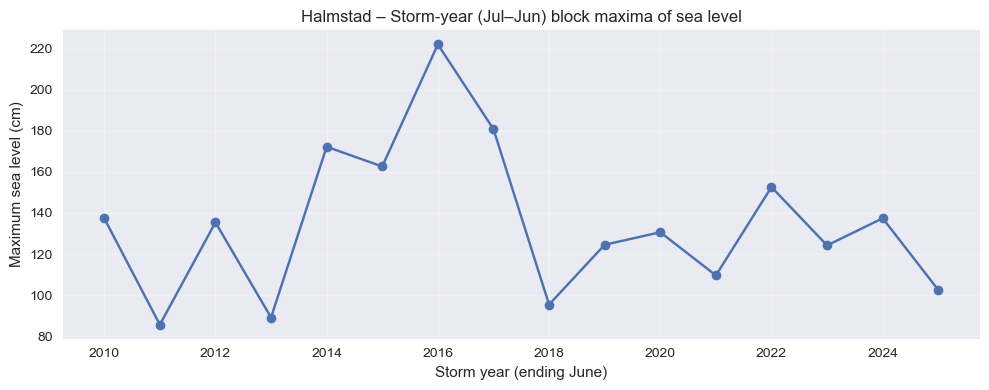

Block years: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]
Y_obs_cm shape: (16,)


In [28]:
# CELL 2 – Load Halmstad sea-level data and create storm-year (Jul–Jun) block maxima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "HALMSTAD SJÖV - RH 2000.csv"

# Load full Halmstad series (semicolon-separated, header on first row)
df_full = pd.read_csv(file_path, sep=";", encoding="utf-8")

# Parse datetime and set as index
df_full["datetime"] = pd.to_datetime(df_full["Datum Tid (UTC)"])
df_full = df_full.set_index("datetime")

# Keep sea level in cm and rename
df_full = df_full[["Havsvattenstånd"]].copy()
df_full = df_full.rename(columns={"Havsvattenstånd": "sea_level_cm"})

# Restrict to a broad time window that comfortably covers 2009–2025 storm years
df_full = df_full.loc["2009-01-01":"2025-12-31"]

print("Full Halmstad series (truncated to 2009–2025):")
print(df_full.head())
print(df_full.tail())
print("Number of observations 2009–2025:", len(df_full))

# Create "storm-year" (Jul–Jun) block maxima
series = df_full["sea_level_cm"].loc["2009-07-01":"2025-06-30"]

# 'A-JUN' = annual frequency with year-end at June 30
storm_year_max = series.resample("A-JUN").max()

# Label each block by the year of the ending June
storm_year_max.index = storm_year_max.index.year
storm_year_max = storm_year_max.sort_index()

print("\nStorm-year (Jul–Jun) block maxima (cm):")
print(storm_year_max)

# Quick plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(storm_year_max.index, storm_year_max.values, marker="o")
ax.set_title("Halmstad – Storm-year (Jul–Jun) block maxima of sea level")
ax.set_xlabel("Storm year (ending June)")
ax.set_ylabel("Maximum sea level (cm)")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Extract arrays for later modelling
block_years = storm_year_max.index.values.astype(int)   # e.g. [2010, 2011, ..., 2024]
Y_obs_cm = storm_year_max.values.astype(float)          # observed block maxima (cm)

print("Block years:", block_years)
print("Y_obs_cm shape:", Y_obs_cm.shape)


In [29]:
# CELL 3 – Load / prepare AR6-based annual MSL sample paths as prior for X_t (in cm)

import numpy as np

# OPTION A: If you still have `varberg_sl_annual` (xarray DataArray) in memory from earlier,
#           you can build from that directly. It has units in mm.
# OPTION B: If you saved it previously with np.savez_compressed as "varberg_sl_annual_2010_2200.npz",
#           load that here. We'll assume OPTION B for reproducibility.

# Load AR6 annual sea-level change for Varberg (mm), extended back to 2010
ar6_data = np.load("varberg_sl_annual_2010_2200.npz")
years_ar6 = ar6_data["years"].astype(int)   # e.g. [2010, 2011, ..., 2200]
sl_mm = ar6_data["sl"]                      # shape: (n_samples, n_years), in mm

print("AR6 Varberg annual sea-level change loaded:")
print("  sl_mm shape:", sl_mm.shape)
print("  years_ar6 range:", years_ar6.min(), "–", years_ar6.max())

# Convert from mm to cm to match Halmstad units
sl_cm = sl_mm / 10.0                        # 10 mm = 1 cm

# For the latent covariate prior, we need X_t for the storm-year block years.
# Our block years correspond to storm seasons Jul(Y-1)–Jun(Y). Conceptually we want
# an MSL covariate associated with "storm-year Y". For simplicity we'll align by calendar year Y.
#
# So we align AR6 years with block_years via intersection:
mask_block = np.isin(years_ar6, block_years)

if not mask_block.any():
    raise ValueError("No overlap between AR6 years and storm-year block years!")

years_for_blocks = years_ar6[mask_block]
X_prior_paths_cm = sl_cm[:, mask_block]     # shape: (n_samples, n_blocks)

print("Years used for blocks:", years_for_blocks)
print("X_prior_paths_cm shape:", X_prior_paths_cm.shape)

# Sanity check: ensure alignment between years_for_blocks and block_years
print("Block years:", block_years)


AR6 Varberg annual sea-level change loaded:
  sl_mm shape: (20000, 91)
  years_ar6 range: 2010 – 2100
Years used for blocks: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]
X_prior_paths_cm shape: (20000, 16)
Block years: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024 2025]


In [30]:
# CELL 4 – Finalize modelling inputs for the latent-X GEV model

# At this point we have:
#   - block_years: 1D array of storm-year labels (e.g. 2010,...,2024)
#   - Y_obs_cm:    1D array of observed storm-year block maxima (cm)
#   - years_for_blocks: AR6 years corresponding to columns of X_prior_paths_cm
#   - X_prior_paths_cm: 2D array [sample, year_index] of AR6-based MSL in cm
#
# For the latent-covariate model, we need X_t for *exactly* the block_years.
# If years_for_blocks and block_years are identical (in order), we are done.
# If not, we align explicitly.

# Build an index mapping AR6 years to columns
year_to_col = {y: i for i, y in enumerate(years_for_blocks)}

cols_for_blocks = []
for y in block_years:
    if y not in year_to_col:
        raise ValueError(f"Block year {y} not found in AR6 years_for_blocks.")
    cols_for_blocks.append(year_to_col[y])
cols_for_blocks = np.array(cols_for_blocks, dtype=int)

# Subset AR6 paths to match the block_year order exactly
X_block_prior_cm = X_prior_paths_cm[:, cols_for_blocks]  # shape: (n_samples, n_blocks)

print("X_block_prior_cm shape:", X_block_prior_cm.shape)
print("Number of AR6 sample paths:", X_block_prior_cm.shape[0])
print("Number of storm-year blocks:", X_block_prior_cm.shape[1])

# Summary:
#   Y_obs_cm         – observed storm-year block maxima (cm), length K
#   block_years      – corresponding storm years
#   X_block_prior_cm – AR6-based prior over latent MSL covariate paths:
#                        each row = one sample path X_t over the K storm years, in cm
#
# A generative scheme for later fitting / simulation:
#
#   1. Draw a path index m ∈ {1,...,M} uniformly (or with weights) → X^{(m)}_t.
#   2. For each block t with latent X_t = X^{(m)}_t, draw
#        Y_t | X_t, θ ∼ GEV( μ_t, σ_t, ξ ),
#      with μ_t = β_0 + β_1 X_t, log σ_t = α_0, ξ constant.
#
# For inference with latent X_t, we will combine:
#   - the empirical prior over paths given by X_block_prior_cm,
#   - the GEV likelihood p(Y_obs_cm | X_block_prior_cm, θ),
# into a joint posterior over (path index, θ), or over a more general X_t if we
# allow mixtures of paths.


X_block_prior_cm shape: (20000, 16)
Number of AR6 sample paths: 20000
Number of storm-year blocks: 16


In [32]:
import numpy as np

# Hack for old libs that still reference np.bool8
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import pymc as pm
import aesara.tensor as at


AttributeError: module 'arviz' has no attribute 'stats'

In [31]:
# CELL 5 – Define GEV log-likelihood helper for PyMC (location–scale–shape parametrisation)

import pymc as pm
import aesara.tensor as at
import numpy as np

def gev_logp(value, mu, sigma, xi):
    """
    Log-density of GEV(value | mu, sigma, xi) in EVT convention:

        z = (y - mu) / sigma
        t = 1 + xi * z
        f(y) = 1/sigma * t^{-1/xi - 1} * exp( - t^{-1/xi} ),  t > 0

    Parameters are allowed to be vectors (broadcast to match `value`).
    """
    z = (value - mu) / sigma
    t = 1.0 + xi * z

    # Elementwise log-density for xi != 0
    log_sigma = at.log(sigma)
    log_t = at.log(t)
    inv_xi = 1.0 / xi
    logp = -log_sigma - (inv_xi + 1.0) * log_t - t ** (-inv_xi)

    # Enforce support t > 0
    logp = at.switch(t <= 0.0, -np.inf, logp)
    return logp


AttributeError: module 'numpy' has no attribute 'bool8'

In [ ]:
# CELL 6 – Build PyMC model with latent AR6 path index and GEV likelihood

with pm.Model() as gev_latent_model:
    # Data: observed storm-year maxima (cm) and AR6 prior paths (cm)
    Y_data = pm.Data("Y_data", Y_obs_cm)                   # shape (K,)
    X_prior_paths = pm.Data("X_prior_paths", X_block_prior_cm)  # shape (M, K)

    n_paths, n_blocks = X_block_prior_cm.shape

    # Prior over AR6 path index m ∈ {0,...,n_paths-1}
    path_probs = np.full(n_paths, 1.0 / n_paths, dtype="float64")
    path_idx = pm.Categorical("path_idx", p=path_probs)

    # Latent covariate path X_t = X_prior_paths[path_idx, :]
    X_latent = X_prior_paths[path_idx]                     # shape (K,)

    # GEV parameters with simple non-stationary location
    # Priors are weakly / physically informed; adjust later as needed.

    # Location: μ_t = β0 + β1 X_t
    beta0 = pm.Normal("beta0", mu=np.mean(Y_obs_cm), sigma=50.0)
    beta1 = pm.Normal("beta1", mu=1.0, sigma=0.5)          # ~1 cm shift in max per 1 cm MSL

    mu_t = pm.Deterministic("mu_t", beta0 + beta1 * X_latent)

    # Scale: log σ_t = α0 (constant scale)
    y_std = np.std(Y_obs_cm, ddof=1)
    alpha0 = pm.Normal("alpha0", mu=np.log(max(y_std, 1.0)), sigma=1.0)
    sigma_t = pm.Deterministic("sigma_t", at.exp(alpha0))

    # Shape ξ: truncated Normal to keep tails reasonable
    xi = pm.TruncatedNormal("xi", mu=-0.1, sigma=0.1, lower=-0.5, upper=0.5)

    # GEV likelihood via custom logp
    Y_like = pm.DensityDist(
        "Y_like",
        mu_t,
        sigma_t,
        xi,
        logp=gev_logp,
        observed=Y_data,
    )
